In [2]:
# Instalando os pacotes necessários para o projeto
! pip install openpyxl
! pip install -U scikit-learn
! pip install matplotlib
! pip install stop-words
! pip install pandas 
! pip install instaloader


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Importando as bibliotecas que serão usadas ao longo do projeto
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from time import sleep
from stop_words import get_stop_words
import matplotlib.pyplot as plt
import pandas as pd
import re

### Coletando os dados diretamente do Instagram
Este trecho de código utiliza a biblioteca `instaloader` para coletar posts do Instagram de um determinado perfil. Esse processo pode levar alguns minutos, dependendo da quantidade de posts.

In [ ]:
# Inicializando o Instaloader e configurando o perfil de interesse
import instaloader

L = instaloader.Instaloader()

# Nome do perfil do Instagram do qual os dados serão coletados
profile_name = 'vanguartfotografia'

# Carregando o perfil
profile = instaloader.Profile.from_username(L.context, profile_name)

# Lista para armazenar os dados dos posts
posts_data = []

# Coletando informações de cada post e armazenando em um dicionário
for post in profile.get_posts():
    try:
        post_data = {
            'Caption': post.caption,
            'Likes': post.likes,
            'MediaCount': post.mediacount,
            'CommentCount': post.comments,
            'TaggedUsers': ', '.join(post.tagged_users) if len(post.tagged_users) > 0 else '',
            'Date': post.date_utc,
            'Is Video': post.is_video,
            'URL': 'https://www.instagram.com/p/' + post.shortcode
        }
        posts_data.append(post_data)
    except Exception as e:
        print(f"An error occurred with post of link: https://www.instagram.com/p/" + post.shortcode)

    # Pausa entre requisições para não sobrecarregar o servidor
    sleep(0.5)

# Transformando os dados coletados em um DataFrame
df = pd.DataFrame(posts_data)

# Salvando os dados coletados em um arquivo CSV para reutilização futura
df.to_csv('instagram_posts.csv', index=False)


### Importando os dados a partir do CSV
Caso os dados já tenham sido coletados anteriormente, podemos carregá-los diretamente de um arquivo CSV para evitar nova coleta.

In [4]:
# Carregando o arquivo CSV com os dados dos posts
df = pd.read_csv('instagram_posts.csv')

### Limpando e ordenando o DataFrame
Neste passo, iremos limpar o DataFrame, removendo posts que não são relevantes para a análise, como aqueles com likes desativados ou anúncios patrocinados.

In [5]:
# Filtrando os posts com mais de 3 likes e menos de 600 likes para eliminar posts com likes desativados e anúncios
df = df[(df['Likes'] > 3) & (df['Likes'] <= 600)]

# Ordenando o DataFrame pelo número de likes em ordem crescente
df = df.sort_values(by='Likes', ascending=True)

# Exibindo os 100 primeiros posts após a filtragem
print(df.head(100))

                                               Caption  Likes  MediaCount  \
58                                essa pequena parte 🤍     32           1   
102  A linda Rayane 💛\n//\n\nCerimonial: @samarasiq...     43           2   
96   Vemos tantas fotos todos os dias agora pelas r...     45           1   
93   E as coisas findas - tão mais que lindas - ess...     47           3   
55   Momentos delicados e sutis como um entrelaçar ...     51           7   
..                                                 ...    ...         ...   
71   Revisitando esse dia lindo por aqui!\nGosto de...    218           8   
155  Caroline + Juarez\nTa chegando o dia do "sim" ...    221           1   
125  A vida é curta demais, não deixe pra depois, s...    228           4   
159  Um bom começo de semana pra vocês com essa fot...    232           1   
51   Um breve resumo do dia de Virginia e Neto 🤍\n_...    246          10   

                    Date  Is Video                                      URL

### Removendo hashtags e menções das legendas
Este trecho remove hashtags e menções nas legendas dos posts para evitar que essas informações interfiram na análise de texto.

In [6]:
# Função para remover hashtags, menções e caracteres especiais
def replace_hashtags_and_mentions(text):
    # Substituindo hashtags e menções por espaços em branco
    text = re.sub(r'#\w+', ' ', text)  # Remove hashtags
    text = re.sub(r'@\w+', ' ', text)  # Remove menções
    text = re.sub(r'\W+', ' ', text)   # Remove caracteres especiais
    text = re.sub(r'\s+', ' ', text).strip()  # Remove espaços múltiplos
    return text

In [7]:
# Aplicando a função de limpeza no DataFrame
df['Cleaned_Caption'] = df['Caption'].apply(replace_hashtags_and_mentions)

# Função para extrair hashtags de um texto
def extract_hashtags(text):
    hashtag_pattern = re.compile(r'#\w+')
    return hashtag_pattern.findall(text)

# Extraindo hashtags das legendas limpas
df['Hashtags'] = df['Cleaned_Caption'].apply(extract_hashtags)

# Exibindo todas as hashtags encontradas
for index, row in df.iterrows():
    if row['Hashtags']:
        print(f"Row {index}: {row['Hashtags']}")

### Análise de frequências das palavras com CountVectorizer
Utilizamos o `CountVectorizer` para converter as legendas em uma matriz de contagem de palavras, ignorando palavras comuns na língua portuguesa.

In [8]:
# Utilizando o CountVectorizer para criar uma matriz de frequência de palavras
vectorizer = CountVectorizer(stop_words=get_stop_words('portuguese'))
X = vectorizer.fit_transform(df['Cleaned_Caption'])

# Convertendo a matriz de frequências para um DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [9]:
# Combinando a coluna de Likes com a matriz de frequências para análise de correlação
df_likes = df[['Likes']].reset_index(drop=True)
X_df = pd.concat([df_likes, X_df], axis=1)

### Calculando correlação entre palavras e likes
Após processar as legendas, calculamos a correlação entre as palavras mais utilizadas e o número de likes que cada post recebeu.

In [10]:
# Calculando a correlação entre palavras e o número de likes
correlation = X_df.corr()['Likes'].sort_values(ascending=False)

# Exibindo a correlação
print(correlation)

Likes          1.000000
bouquet        0.449981
povo           0.430178
locação        0.413588
obrigado       0.371778
                 ...   
vezes         -0.155767
importantes   -0.157334
detalhes      -0.163306
memórias      -0.166186
tempo         -0.173948
Name: Likes, Length: 1463, dtype: float64


### Visualizando correlações
Criamos um gráfico de barras horizontal para exibir as palavras mais correlacionadas com o número de likes recebidos.


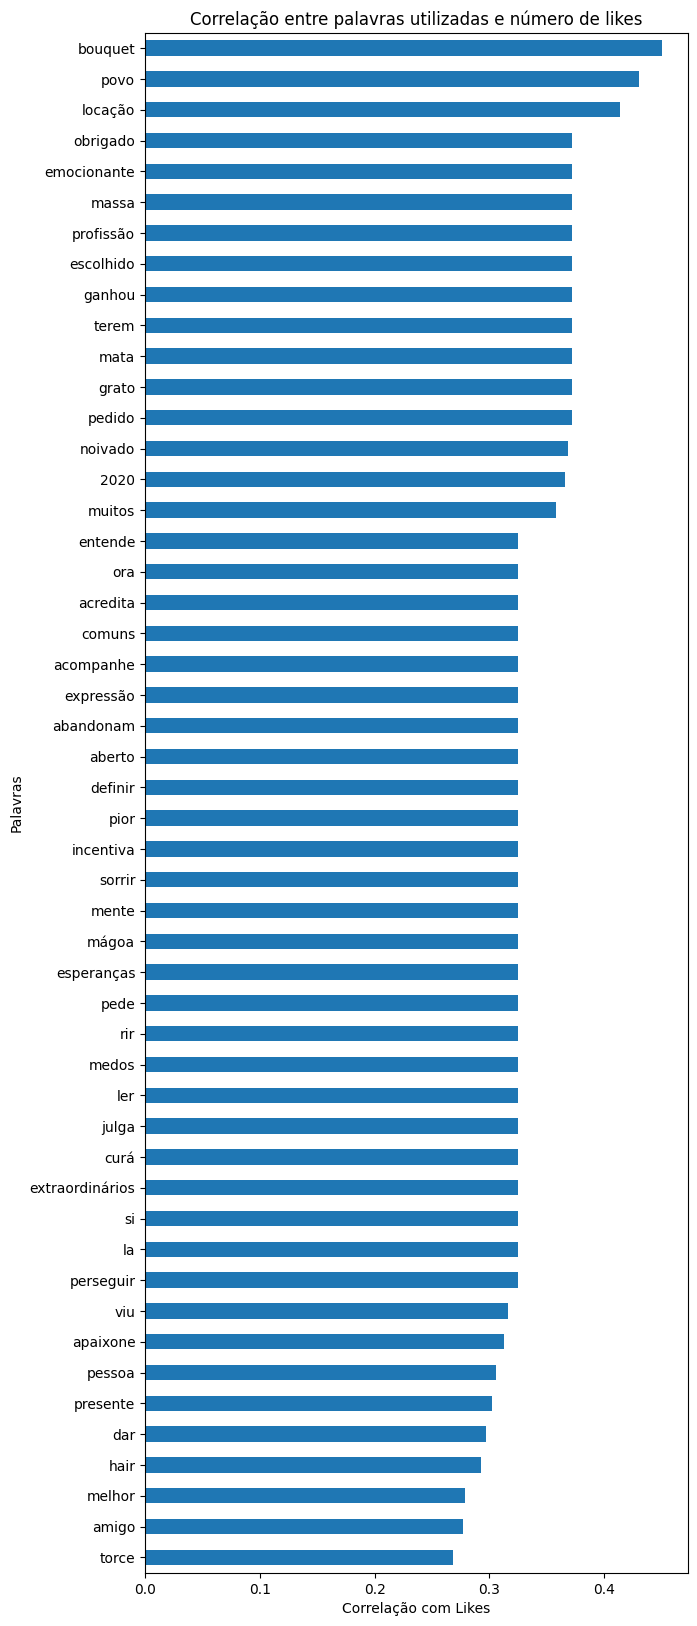

In [11]:
# Gerando gráfico das 50 palavras mais correlacionadas positivamente com likes
plt.figure(figsize=(7, 20))
correlation[1:51].sort_values(ascending=True).plot(kind='barh')
plt.title('Correlação entre palavras utilizadas e número de likes')
plt.xlabel('Correlação com Likes')
plt.ylabel('Palavras')
plt.show()

### Utilizando TF-IDF para análise de relevância das palavras
Além da contagem de palavras, utilizamos o `TfidfVectorizer` para calcular o peso relativo de cada palavra nas legendas, a fim de determinar sua importância em relação aos likes.


In [12]:
# Utilizando o TfidfVectorizer para análise de relevância de palavras
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['Caption'])

# Convertendo a matriz TF-IDF para um DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [13]:
# Combinando o DataFrame TF-IDF com a coluna de likes
X_tfidf_df = pd.concat([df_likes, X_tfidf_df], axis=1)

# Calculando a correlação entre termos TF-IDF e o número de likes
correlation_tfidf = X_tfidf_df.corr()['Likes'].sort_values(ascending=False)

# Exibindo a correlação
print(correlation_tfidf)

Likes                     1.000000
timbauba                  0.535365
agameoftones              0.532833
ensaiofotográfico         0.532833
fotografosdepernambuco    0.532833
                            ...   
mas                      -0.161268
importantes              -0.161534
momentos                 -0.161759
tempo                    -0.167050
memórias                 -0.192168
Name: Likes, Length: 1701, dtype: float64


### Visualizando correlações de TF-IDF
Visualizamos a correlação das palavras, levando em conta o peso de suas aparições através do TF-IDF, com o número de likes recebidos por post.


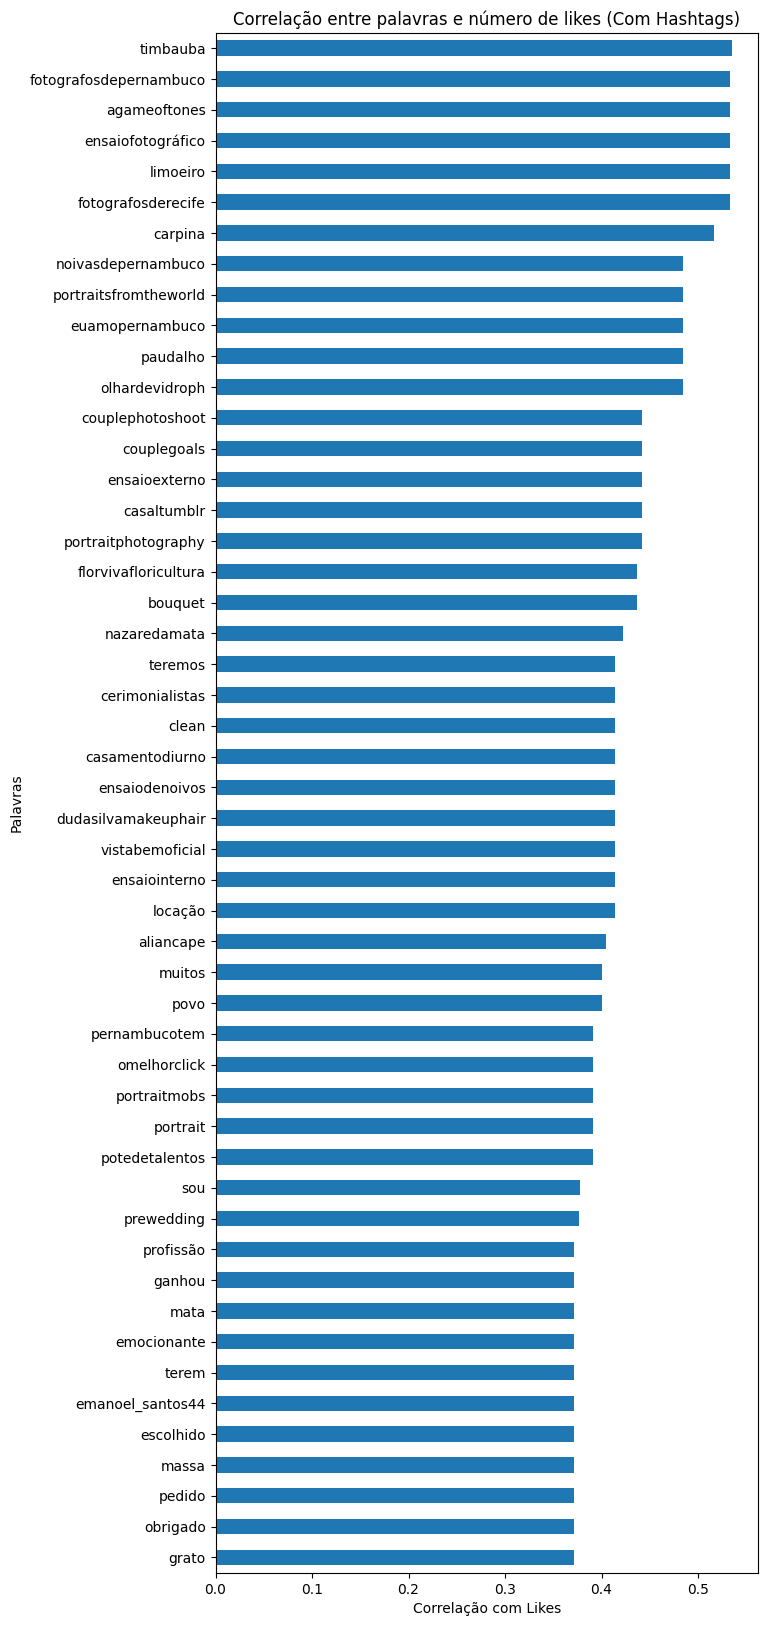

In [14]:
# Gerando gráfico das 50 palavras mais correlacionadas com likes utilizando TF-IDF
plt.figure(figsize=(7, 20))
correlation_tfidf[1:51].sort_values(ascending=True).plot(kind='barh')
plt.title('Correlação entre palavras e número de likes (Com Hashtags)')
plt.xlabel('Correlação com Likes')
plt.ylabel('Palavras')
plt.show()

### Considerações Finais
Este notebook realiza a coleta, limpeza e análise de dados de posts do Instagram utilizando técnicas de processamento de linguagem natural para identificar quais palavras nas legendas estão mais correlacionadas com o número de likes recebidos. As visualizações geradas ajudam a entender melhor a influência do conteúdo textual nas interações dos posts.

**Sugestões para melhorias futuras:**
- Análise de sentimentos das legendas para verificar o impacto do sentimento no engajamento.
- Utilização de modelos preditivos para estimar o número de likes com base nas características do post.
- Análise de outras métricas como compartilhamentos e salvamentos, se disponíveis.